In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input
from keras import backend as K
from keras import layers, models
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

from spec_generator_sequence import spec_generator
from spec_generator_sequence_multilabel import (spec_generator_multi,
                                                spec_generator_multioutput)
from spec_input_generator import gen, gen_eval
from spectrogram_class import spectrogram


In [35]:

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-07-25 15:24:35.863021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2022-07-25 15:24:35.901674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 15:24:35.939438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 15:24:35.940401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 15:24:36.815646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 15:24:36.816082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [36]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')

In [37]:
meta_df.shape

(13265, 17)

In [38]:
meta_df = meta_df[~meta_df['Pitch ID (if applicable)'].isna()]

In [39]:
meta_df.isna().sum()

Path                              0
Family (abbr.)                    0
Family (in full)                  0
Instrument (abbr.)                0
Instrument (in full)              0
Technique (abbr.)                 0
Technique (in full)               0
Pitch                             0
Pitch ID (if applicable)          0
Dynamics                          0
Dynamics ID (if applicable)     568
Instance ID                       0
Mute (abbr.)                      0
Mute (in full)                    0
String ID (if applicable)      5666
Needed digital retuning           0
Fold                              0
dtype: int64

In [40]:
meta_df.shape

(13162, 17)

In [41]:
meta_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0


In [42]:
from random import random


train_df, test_df = train_test_split(meta_df, stratify=meta_df['Instrument (in full)'], 
                                            train_size=0.7, random_state= 42)

In [43]:
multi_generator = spec_generator_multi(train_df, 32)

In [44]:
_, num_target = multi_generator.__getitem__(2)[1].shape
print(num_target)

107


In [45]:
_, num_row, num_col, _= multi_generator.__getitem__(2)[0].shape
print(num_row)
print(num_col)

500
256


In [46]:
BATCH_SIZE = 32


train_generator = (tf.data.Dataset.from_generator(lambda: spec_generator_multi(train_df, BATCH_SIZE), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((BATCH_SIZE, num_row, num_col), 
                 (BATCH_SIZE, num_target)))).prefetch((tf.data.experimental.AUTOTUNE))

eval_generator = (tf.data.Dataset.from_generator(lambda: spec_generator_multi(test_df, BATCH_SIZE), 
                    output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((BATCH_SIZE, num_row, num_col), 
                 (BATCH_SIZE, num_target)))).prefetch((tf.data.experimental.AUTOTUNE))


2022-07-25 15:24:37.757406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 15:24:37.758063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 15:24:37.758420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 15:24:37.759920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 15:24:37.760357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [14]:


rnn = Sequential()

rnn.add(layers.InputLayer((num_row, num_col), batch_size= BATCH_SIZE))
rnn.add(LSTM(500))
rnn.add(layers.Dropout(0.2))
rnn.add(layers.Dense(50, activation = 'relu'))
rnn.add(layers.Dense(num_target, activation = 'sigmoid'))



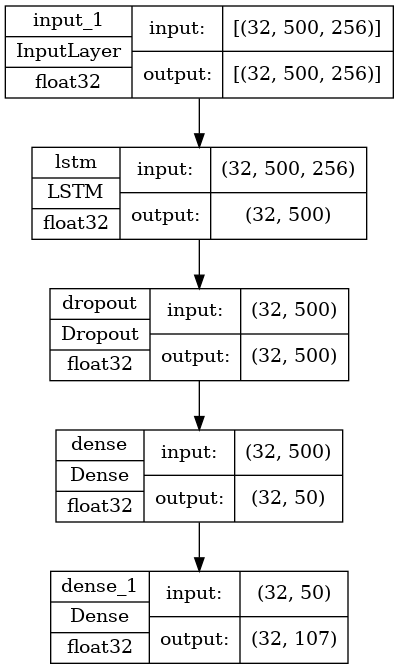

In [15]:
tf.keras.utils.plot_model(rnn, show_shapes = True, show_dtype= True)

In [25]:
rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])

In [ ]:
from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


history = rnn.fit(train_generator, epochs = 4, verbose=1, 
                    validation_data = eval_generator,
                    validation_steps = 10, validation_freq= 2, 
                    use_multiprocessing=True, workers = 2, callbacks=[ckpt_callback, early_callback])

In [ ]:
test = meta_df.sample(1)[['Path', 'Instrument (in full)', 'Pitch ID (if applicable)']]

In [ ]:
test

In [ ]:
test_spec = spectrogram(test['Path'].values[0])

In [ ]:
test_spec.spec

In [ ]:
test_spec.spec.shape

In [ ]:
np.reshape(test_spec.spec, (256, 500, 1)).shape

In [ ]:
np.reshape(multi_generator.__getitem__(2)[0]).shape

In [ ]:
rnn.predict_(multi_generator.__getitem__(2)[0])[0]

In [ ]:
multi_generator.__getitem__(2)[0][0].shape

# Rnn two onte-hot target

In [ ]:
from unicodedata import name


inp = Input((num_row, num_col), batch_size=BATCH_SIZE, )
x = LSTM(50)(inp)
x = layers.Dropout(0.2)(x)
x = layers.Dense(50, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
out1 = layers.Dense(16, activation = 'softmax', name = 'out1')(x)

y = LSTM(50)(inp)
y = layers.Dropout(0.2)(y)
y = layers.Dense(50, activation = 'relu')(y)
y = layers.BatchNormalization()(y)
out2 = layers.Dense(107-16, activation = 'softmax', name = 'out2')(y)

model_2conv_two_out = Model(inp, [out1, out2])

In [ ]:
tf.keras.utils.plot_model(model_2conv_two_out, show_shapes=True, show_dtype=True)

In [ ]:
model_2conv_two_out.summary()

In [ ]:
model_2conv_two_out.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss={'out1': tf.keras.losses.CategoricalCrossentropy(),
                    'out2': tf.keras.losses.CategoricalCrossentropy()},
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [47]:
multioutput_generator = spec_generator_multioutput(train_df, 4)
multioutput_test_generator = spec_generator_multioutput(test_df, 4)

In [ ]:
# model_2conv_two_out = models.load_model('../models/rnn/first/')

In [ ]:
from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn_multioutput", 
                                                    monitor='val_accuracy',
                                                    save_freq = 287*5)
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

history = model_2conv_two_out.fit(multioutput_generator, epochs=100, 
                        validation_data= multioutput_test_generator, 
                        callbacks=[ckpt_callback])

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
model_2conv_two_out.save('../models/rnn_normalized/second')

In [ ]:
%load_ext tensorboard

In [ ]:
!tensorboard dev upload \
    -y \
  --logdir logs \
  --name "Sample op-level graph" \
  --one_shot

# Conv + RNN

In [48]:
multioutput_generator_convlstm = spec_generator_multioutput(train_df, 8)
multioutput_test_generator_convlstm = spec_generator_multioutput(test_df, 8)

In [49]:

inp = Input((num_row, num_col, 1), batch_size=8, )
x = layers.ConvLSTM1D(20, 15, kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(inp)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(30, (30))(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(30, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
out1 = layers.Dense(16, activation = 'softmax', name = 'out1')(x)

y = layers.ConvLSTM1D(20, 15, kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(inp) 
y = layers.Dropout(0.2)(y)
y = layers.MaxPooling1D(2)(y)
y = layers.Conv1D(30, (30))(y)
y = layers.MaxPooling1D(2)(y)
y = layers.Flatten()(y)
y = layers.Dense(30, activation = 'relu')(y)
y = layers.BatchNormalization()(y)
out2 = layers.Dense(107-16, activation = 'softmax', name = 'out2')(y)

model_convlstm = Model(inp, [out1, out2])

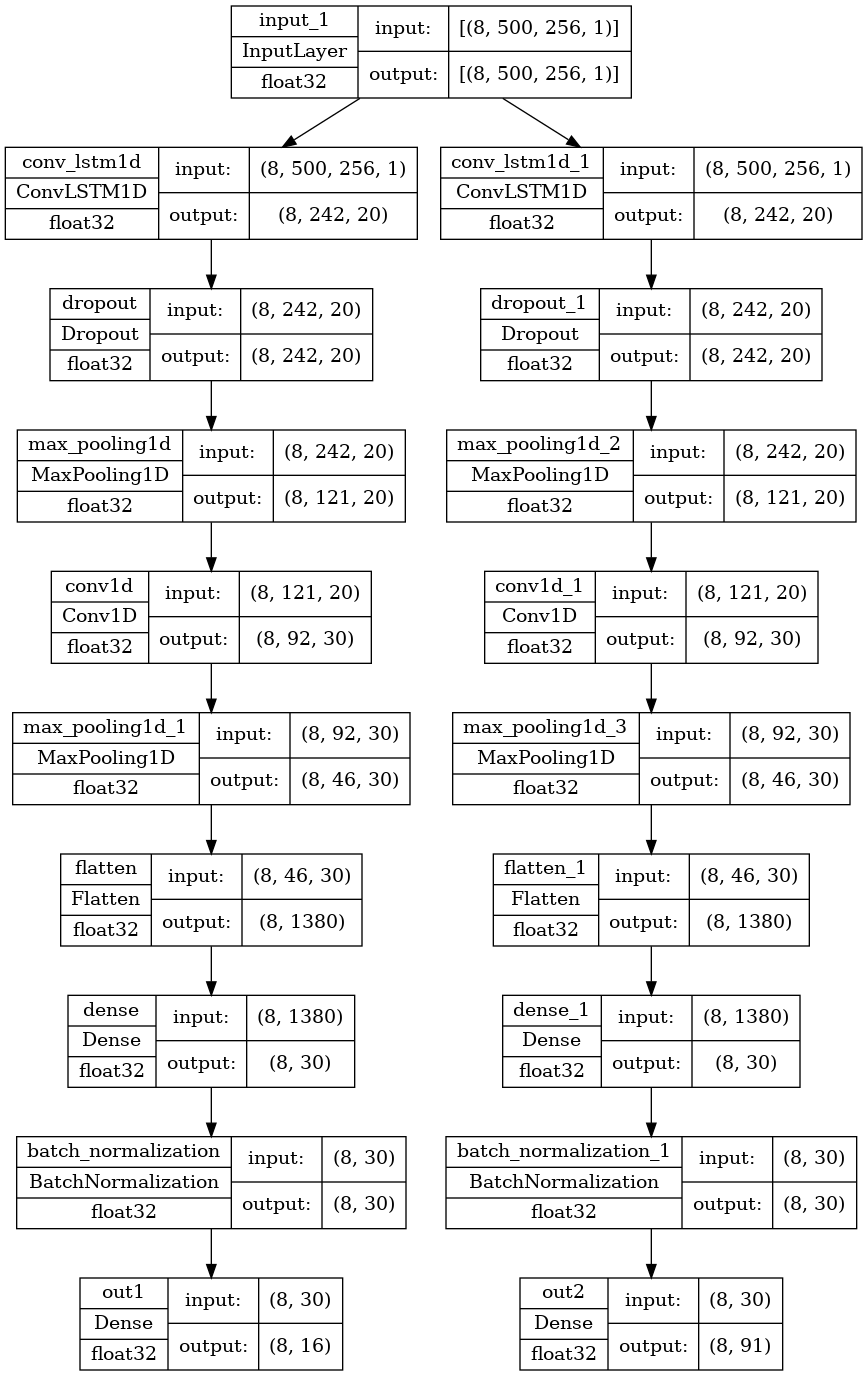

In [50]:
tf.keras.utils.plot_model(model_convlstm , show_shapes=True, show_dtype=True)

In [51]:
model_convlstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(8, 500, 256, 1)]   0           []                               
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (8, 242, 20)         25280       ['input_1[0][0]']                
                                                                                                  
 conv_lstm1d_1 (ConvLSTM1D)     (8, 242, 20)         25280       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (8, 242, 20)         0           ['conv_lstm1d[0][0]']            
                                                                                              

In [52]:

model_convlstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss={'out1': tf.keras.losses.CategoricalCrossentropy(),
                    'out2': tf.keras.losses.CategoricalCrossentropy()},
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [53]:
!pwd

/bin/bash: /home/shiya/anaconda3/envs/music/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/shiya/Documents/music_transcription/notebooks


In [54]:
new_path = !find ../models/baseline_checkpoint/*rnn_convlstm -maxdepth 0 | sort -nr | head -1
new_path = new_path[1]

In [55]:
print(new_path)

../models/baseline_checkpoint/20220725_132741_02_rnn_convlstm


In [56]:
model_convlstm = tf.keras.models.load_model(new_path)

In [57]:

from datetime import datetime

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_rnn_convlstm", 
                                                    monitor='val_accuracy',
                                                    save_freq = 287*5)
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

history_convlstm = model_convlstm.fit(multioutput_generator_convlstm, epochs=100, 
                        validation_data= multioutput_test_generator_convlstm, 
                        callbacks=[ckpt_callback])

Epoch 1/100


2022-07-25 15:25:27.376327: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-25 15:25:28.017029: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-25 15:25:28.018021: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-25 15:25:28.018164: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-25 15:25:28.019539: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-25 15:25:28.019861: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 172/1151 [===>..........................] - ETA: 48:06 - loss: 6.8081 - out1_loss: 2.5647 - out2_loss: 4.2339 - out1_accuracy: 0.1468 - out1_auc_4: 0.6854 - out2_accuracy: 0.0174 - out2_auc_4: 0.6911

In [48]:
model_convlstm.save('../models/rnn_convlstm/first')

INFO:tensorflow:Assets written to: ../models/rnn_convlstm/first/assets


INFO:tensorflow:Assets written to: ../models/rnn_convlstm/first/assets
